# FNet training example

## Training

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import models
from tensorflow.keras import backend as K

In [2]:
import os
import numpy as np
import pandas as pd

from scipy import stats

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.figsize'] = (8,8)

# For MAT importing function
import scipy.io
import re

import functools

import gc

### Import train dataset from MAT files

In this example, we will use images of 64 X 64 pixel size, because larger images require huge memories and computing powers for training and typically cannot be finished in a short time in typical computers. For a practical training for experiment images, usage of CUDA supported GPUs is recommended.

In [62]:
img_shape = (64, 64, 128)

In [28]:
MAT_path='training_example'

subdir_new=os.listdir(MAT_path);

x_train_filenames = []
y_train_filenames = []
all_filenames=[]

for subdir in subdir_new:
    if os.path.isdir(os.path.join(MAT_path, subdir)):
        for files in os.listdir(os.path.join(MAT_path, subdir)):
            all_filenames.append(os.path.join(MAT_path, subdir,files))

We will train all images with various simulation conditions together in this example. For the practical use, we carefully selected training dataset after reviewing the training result; for more information check **Adaptive training** section of the paper.

In [29]:
#MAT file Corruption check
for matfile in all_filenames:
    try:
        scipy.io.loadmat(matfile)
    except:
        print(f'{matfile}')

In [30]:
re_train=re.compile('.*_train.mat')
re_label=re.compile('.*_label.mat')

x_train_filenames = list(filter(re_train.match,all_filenames))
y_train_filenames = list(filter(re_label.match,all_filenames))

x_train_filenames.sort()
y_train_filenames.sort()

#train label pairng check
for file_index in range(0,len(x_train_filenames)):
    if not x_train_filenames[file_index][0:-10]==y_train_filenames[file_index][0:-10]:
        print(file_index)
        print(x_train_filenames[file_index])

In [31]:
from sklearn.model_selection import train_test_split

In [32]:
x_train_filenames, x_val_filenames, y_train_filenames, y_val_filenames = train_test_split(x_train_filenames, y_train_filenames, test_size=10, random_state=42)

In [56]:
len(x_train_filenames)

260

In [33]:
num_train_examples_ = len(x_train_filenames)
num_val_examples_ = len(x_val_filenames)

print("Number of training examples: {}".format(num_train_examples_))
print("Number of validation examples: {}".format(num_val_examples_))

Number of training examples: 260
Number of validation examples: 10


In [34]:
batch_size = 2
epochs = 3

### Augmentation

In [11]:
def shift_img(output_img, label_img, width_shift_range, height_shift_range): #we don't shift images in this example, simulated fibrils are already randomly shifted
  if width_shift_range or height_shift_range:
      if width_shift_range:
        width_shift_range = tf.random.uniform([], 
                                              -width_shift_range * img_shape[1],
                                              width_shift_range * img_shape[1])
      if height_shift_range:
        height_shift_range = tf.random.uniform([],
                                               -height_shift_range * img_shape[0],
                                               height_shift_range * img_shape[0])
  return output_img, label_img
  
def flip_img(horizontal_flip, tr_img, label_img):
  tr_img.shape
  if horizontal_flip:
    flip_prob = tf.random.uniform([], 0.0, 1.0)
    tr_img, label_img = tf.cond(tf.less(flip_prob, 0.5),
                                lambda: (tf.image.flip_left_right(tr_img), tf.image.flip_left_right(label_img)),
                                lambda: (tr_img, label_img))
  return tr_img, label_img
  
def _augment(img,
             label_img,
             resize=None,  # Resize the image to some size e.g. [256, 256]
             scale=1,  # Scale image e.g. 1 / 255.
             hue_delta=0,  # Adjust the hue of an RGB image by random factor
             horizontal_flip=False,  # Random left right flip,
             width_shift_range=0,  # Randomly translate the image horizontally
             height_shift_range=0):  # Randomly translate the image vertically 
  
  img, label_img = flip_img(horizontal_flip, img, label_img)
  
  img = img * scale #scale img only
  return img, label_img

### Define tensorflow generators

In [12]:
def import_MAT(fname):
	re_label=re.compile('.*label.mat')
	re_train=re.compile('.*train.mat')
	
	if re_label.match(fname):
		mat_type='label_img'
	
	if re_train.match(fname):
		mat_type='train_img'
	
	new_img=np.zeros(img_shape)
	mat = scipy.io.loadmat(fname)
	mat = mat[mat_type]
	channels=min(img_shape[2],mat.shape[-1])
	new_img[:,:,0:channels]=mat[:,:,0:channels]
	return new_img

In [35]:
train_file_tuple=[(x_train_filenames[i], y_train_filenames[i]) for i in range(0,len(x_train_filenames))]
val_file_tuple=[(x_val_filenames[i], y_val_filenames[i]) for i in range(0,len(x_val_filenames))]

def train_gen():
    for el in train_file_tuple:
        yield (import_MAT(el[0]),import_MAT(el[1]))

def val_gen():
    for el in val_file_tuple:
        yield (import_MAT(el[0]),import_MAT(el[1]))

In [36]:
def get_baseline_dataset(file_tuple,gen,
                         preproc_fn=functools.partial(_augment),
                         threads=8, 
                         batch_size=batch_size,
                         shuffle=True):           
    
  dataset = tf.data.Dataset.from_generator(gen,(tf.float64, tf.float64),(tf.TensorShape(img_shape), tf.TensorShape(img_shape)))

  if preproc_fn.keywords is not None and 'resize' not in preproc_fn.keywords:
    assert batch_size == 1, "Batching images must be of the same size"

  dataset = dataset.map(preproc_fn, num_parallel_calls=threads)

  if shuffle:
    dataset = dataset.shuffle(batch_size*20)
    
  dataset = dataset.repeat().batch(batch_size)
  return dataset

In [37]:
tr_cfg = {
    'resize': [img_shape[0], img_shape[1]],
    'scale': 1 / 100.,
    'hue_delta': 0.1,
    'horizontal_flip': True,
    'width_shift_range': 0.1,
    'height_shift_range': 0.1
}
tr_preprocessing_fn = functools.partial(_augment, **tr_cfg)

val_cfg = {
    'resize': [img_shape[0], img_shape[1]],
    'scale': 1 / 100.,
}
val_preprocessing_fn = functools.partial(_augment, **val_cfg)

train_ds = get_baseline_dataset(train_file_tuple,
                                train_gen,
                                preproc_fn=tr_preprocessing_fn,
                                batch_size=batch_size)

val_ds = get_baseline_dataset(val_file_tuple,
                              val_gen,
                              preproc_fn=val_preprocessing_fn,
                              batch_size=batch_size)

### Model

In [38]:
def dice_coeff(y_true, y_pred):
    smooth = 1.
    
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(tf.square(y_true_f)) + tf.reduce_sum(tf.square(y_pred_f)) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

In [39]:
from FNet.FNet import FNet

base_feature = 4
model=FNet(base_feature, img_shape)

In [40]:
model.compile(optimizer='adam', loss=dice_loss)

In [41]:
save_model_path = 'model_example'
cp = tf.keras.callbacks.ModelCheckpoint(filepath=save_model_path, save_best_only=True, save_weights_only=True, verbose=1)

In [42]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 64, 64, 128) 0                                            
__________________________________________________________________________________________________
tf_op_layer_strided_slice_128 ( [(None, 64, 64, 1)]  0           input_2[0][0]                    
__________________________________________________________________________________________________
enc_block_5 (enc_block)         ((None, 32, 32, 4),  220         tf_op_layer_strided_slice_128[0][
__________________________________________________________________________________________________
enc_block_6 (enc_block)         ((None, 16, 16, 8),  944         enc_block_5[0][0]                
____________________________________________________________________________________________

### Train the model

In [43]:
history = model.fit(train_ds, 
                   steps_per_epoch=int(np.ceil(num_train_examples_ / float(batch_size))),
                   epochs=epochs,
                   validation_data=val_ds,
                   validation_steps=int(np.ceil(num_val_examples_ / float(batch_size))),
                   callbacks=[cp])

Train for 130 steps, validate for 5 steps
Epoch 1/3
129/130 [============================>.] - ETA: 14s - loss: 0.7541
Epoch 00001: val_loss improved from inf to 0.91371, saving model to model_example
130/130 [==============================] - 1918s 15s/step - loss: 0.7547 - val_loss: 0.9137
Epoch 2/3
129/130 [============================>.] - ETA: 3s - loss: 0.6762
Epoch 00002: val_loss improved from 0.91371 to 0.73826, saving model to model_example
130/130 [==============================] - 514s 4s/step - loss: 0.6760 - val_loss: 0.7383
Epoch 3/3
129/130 [============================>.] - ETA: 4s - loss: 0.6684
Epoch 00003: val_loss improved from 0.73826 to 0.69701, saving model to model_example
130/130 [==============================] - 533s 4s/step - loss: 0.6685 - val_loss: 0.6970


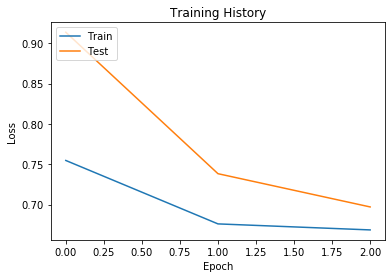

In [44]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training History')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Due to the short training, the result is not good enough. In the training for the practical analysis, typically validation loss reaches <0.1 after 3 epochs of 100,000 training images.

### Check predictions

In [46]:
def one_shot_predictor(model, next_img, prev_cl=0, norm_factor=100.):
	img_shape = model.input_shape[1:]
	if not isinstance(prev_cl, (list, tuple, np.ndarray)):
		empty_pred=np.zeros(img_shape)
		prev_cl=empty_pred
		bkg = np.median(next_img)
		empty_pred[...,1]=bkg#np.random.poisson(np.median(next_img),empty_pred.shape[0:2]) #fill the bkg channel
	else:
		bkg = prev_cl[:,:,1].mean()
	img=np.zeros(img_shape)
	img[:,:,0]=next_img
	img[:,:,1:]=prev_cl[:,:,1:]
	
	img/=norm_factor
	
	return norm_factor*model.predict(np.expand_dims(img,axis=0))[0] #expand dim to make it a batch of size 1

In [47]:
test_x_fname = x_train_filenames[0]
test_y_fname = y_train_filenames[0]

In [48]:
x_img = import_MAT(test_x_fname)
label_img = import_MAT(test_y_fname)

In [49]:
print(f'x={test_x_fname}\ny={test_y_fname}')

x=training_example/d2a3p3g1/2021-08-25-2127m31sN13d2a3p3g1_train.mat
y=training_example/d2a3p3g1/2021-08-25-2127m31sN13d2a3p3g1_label.mat


In [51]:
new_pred = one_shot_predictor(model, x_img[...,0], x_img)

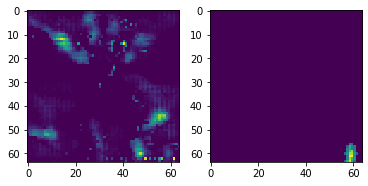

In [58]:
plt.subplot(1,2,1)
plt.imshow(new_pred[...,10])
plt.subplot(1,2,2)
plt.imshow(label_img[...,10])

## Clustering of predictions

Clustering of new fibrils

In [32]:
testImg=one_img(imgs,1,5)
testPred=one_shot_predictor(model, testImg)

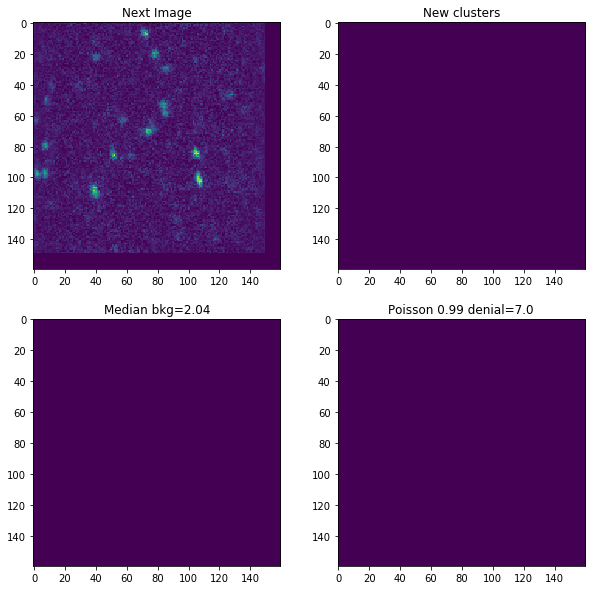

In [33]:
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.imshow(testImg)
plt.title("Next Image")

plt.subplot(2, 2, 2)
plt.imshow(testPred[:,:,0])
plt.title("New clusters")

bkg=np.median(testImg)
poissBkg=stats.poisson.interval(bkgP,bkg)[1]

plt.subplot(2, 2, 3)
plt.imshow(testPred[:,:,0]*testImg>bkg)
plt.title(f"Median bkg={bkg:.3}")

plt.subplot(2, 2, 4)
plt.imshow(testPred[:,:,0]*testImg>poissBkg)
plt.title(f"Poisson {bkgP:.3} denial={poissBkg}")

plt.show()

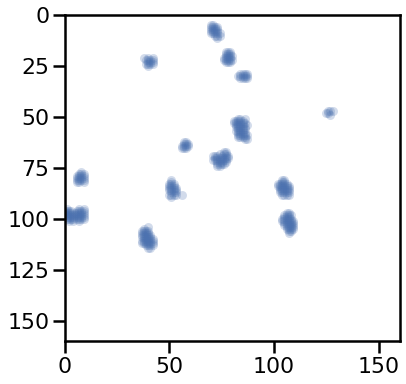

In [26]:
plt.figure(figsize=(6, 6))
plt.scatter(data.T[1], data.T[0], c='b', **plot_kwds)
plt.xlim(0,160)
plt.ylim(0,160)

frame = plt.gca()
frame.invert_yaxis()

#frame.axes.get_xaxis().set_visible(False)
#frame.axes.get_yaxis().set_visible(False)

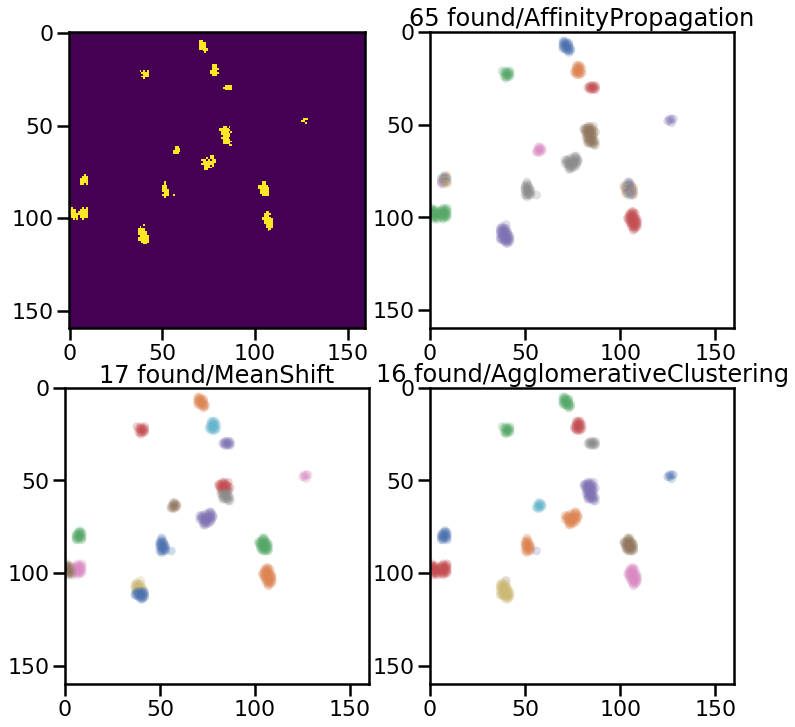

In [28]:
plt.figure(figsize=(12, 12))
plt.subplot(2,2,1)
plt.imshow(clusterImgTest)

plt.subplot(2,2,2)
plot_clusters(data, cluster.AffinityPropagation, (), {'preference':-1000, 'damping':0.5})

#plt.figure(figsize=(6, 6))
plt.subplot(2,2,3)
plot_clusters(data, cluster.MeanShift, (3,), {'cluster_all':True})

#plt.figure(figsize=(6, 6))
plt.subplot(2,2,4)
plot_clusters(data, cluster.AgglomerativeClustering, (), {'n_clusters':None, 'linkage':'single', 'distance_threshold':dist_crit})

for the known fibrils, we will choose the biggest cluster.

Define a function to convert a new cluster img to individual cluster imgs

In [36]:
def find_z_available(cluster_img):
    z_available=np.arange(0,cluster_img.shape[2])[np.isclose([np.max(cluster_img[:,:,z]) for z in range(0,cluster_img.shape[2])],0)]
    
    return z_available[z_available>1]

In [37]:
def find_z_unavailable(cluster_img):
    z_available=find_z_available(cluster_img)
    return [z for z in range(2,cluster_img.shape[2]) if not np.isin(z,z_available)]

In [38]:
def get_cluster_image(new_pred, next_img, prev_pred=0, clustering=True, thresholding=False, minimumSize=10,normalization=True):
    '''
    The followings are for known clusters. For new cluseters, bkg threshold applied automatically
    
    thresholding=True # ignore signals below bkg_mul*bkg (else, below bkg)
    clustering=True # only choose the biggest cluster above bkg
    normalization=True # correct leakages into unused layers
    '''
    #thresholding=True
    #clustering=True
    #new_pred=testPred
    #next_img=testImg
    #prev_pred=0
    cluster_image=new_pred.copy()
    bkg=np.median(next_img)
    if thresholding: #higher bkg thresholding
        bkg=stats.poisson.interval(bkgP,bkg)[1]

    cluster_image[...,0]=next_img
    cluster_image[...,1]*=next_img #background

    if not isinstance(prev_pred, (list, tuple, np.ndarray)):
        z_available=np.arange(2,img_shape[2])
        z_unavailable=[]
    else:
        z_available=find_z_available(prev_pred)
        z_unavailable=find_z_unavailable(prev_pred)
        
    #Known clusters bkg thresholding
    for z in z_unavailable:
        new_pred_z=cluster_image[...,z]
        new_pred_z[(next_img*new_pred_z) <= bkg]=0 #erase signals below threshold
    
    for z in z_available:
        if normalization:
            cluster_image[...,0]+=cluster_image[...,z]
        cluster_image[...,z]=0
        '''
        label_sum=cluster_image[:,:,1:].sum(2);

        for nonzero_index in np.argwhere(np.logical_not(np.isclose(label_sum,0))):
            cluster_image[nonzero_index[0],nonzero_index[1],1:]/=label_sum[nonzero_index[0],nonzero_index[1]];

        for zero_index in np.argwhere(np.isclose(label_sum,0)):
            cluster_image[zero_index[0],zero_index[1],1]=1;
        '''
    
    #clustering of known clusters' signals
    if clustering:
        for z in z_unavailable:
            new_pred_z=cluster_image[...,z].copy()
            cluster_image[...,z]=0
            
            z_clusters_locations=np.array(np.nonzero(new_pred_z*next_img>bkg)).T
            
            if z_clusters_locations.shape[0]>minimumSize: #more than minimumSize pixel of cluster
                labels=cluster.AgglomerativeClustering(n_clusters=None, linkage='single',distance_threshold=dist_crit).fit_predict(z_clusters_locations)

                largest_index=stats.mode(labels)
                largest_index=largest_index[0]

                cluster_locations=[x for x in z_clusters_locations[labels==largest_index,:]]
                    
                for x in cluster_locations:
                    cluster_image[tuple(np.append(x,z))]=new_pred_z[tuple(x)]
            #else: #cluster became smaller.
                #new_pred_z[new_pred_z*next_img<=bkg]=0
                #cluster_image[...,z]=new_pred_z
                
                #do nothing. the cluster disappeared.

    # for new clusters
    new_clusters=(new_pred[...,0]*next_img)>bkg
    
    if np.any(new_clusters) and z_available.size>0:
        new_clusters_locations=np.array(np.nonzero(new_clusters)).T
        if new_clusters_locations.shape[0]>minimumSize: #more than minimumSize pixel of new cluster
            labels=cluster.AgglomerativeClustering(n_clusters=None, linkage='single',distance_threshold=dist_crit).fit_predict(new_clusters_locations)
            n_new=0
            z_index=0
            for index in np.unique(labels):
                if not z_available.size>z_index: #no more space
                    print('No more space')
                    break
                    
                cluster_locations=[x for x in new_clusters_locations[labels==index,:]]
                if len(cluster_locations) <= minimumSize: #skip small cluster
                    continue
                else:
                    n_new+=1
                    z_index+=1
                    
                for x in cluster_locations:
                        cluster_image[tuple(np.append(x,z_available[z_index-1]))]=new_pred[tuple(np.append(x,0))]
                    
        else: #less than minimumSize
            #cluster_image[...,lastNonzero_ch_prev]=new_pred[...,0]
            #n_new=1
            
            n_new=0
    else:
        n_new=0

    for z in z_unavailable:
        cluster_image[:,:,z]*=next_img
    for z in z_available[0:n_new]:
        cluster_image[:,:,z]*=next_img
    
    return cluster_image

In [43]:
def plot_25_clusters(next_cluster_image):
    plt.figure(figsize=(15,15))
    for i in range (0,25):
        plt.subplot(5,5,i+1)
        plt.imshow(next_cluster_image[:,:,i])
        plt.title(f'Max={next_cluster_image[:,:,i].max():3.2}')

from an experiment,

In [51]:
whole_cluster_imgs=np.zeros(whole_img_shape)

In [57]:
for region_index in range(0,len(regions)):
    next_img = one_img(imgs,regions[region_index],0)
    whole_cluster_imgs[...,region_index,0]=get_cluster_image(one_shot_predictor(model, next_img),next_img,minimumSize=minimum_size)
    for imgseq in range(1,N_imglen):
        try:
            next_img = one_img(imgs,regions[region_index],imgseq)
            whole_cluster_imgs[...,region_index,imgseq]=get_cluster_image(one_shot_predictor(model, next_img, whole_cluster_imgs[...,region_index,imgseq-1]),next_img, whole_cluster_imgs[...,region_index,imgseq-1],minimumSize=minimum_size)
        except: #due to incomplete imaging
            print('a break at Region=',regions[region_index],',Time=',imgseq)
            break

a break at Region= 8 ,Time= 66
a break at Region= 10 ,Time= 66


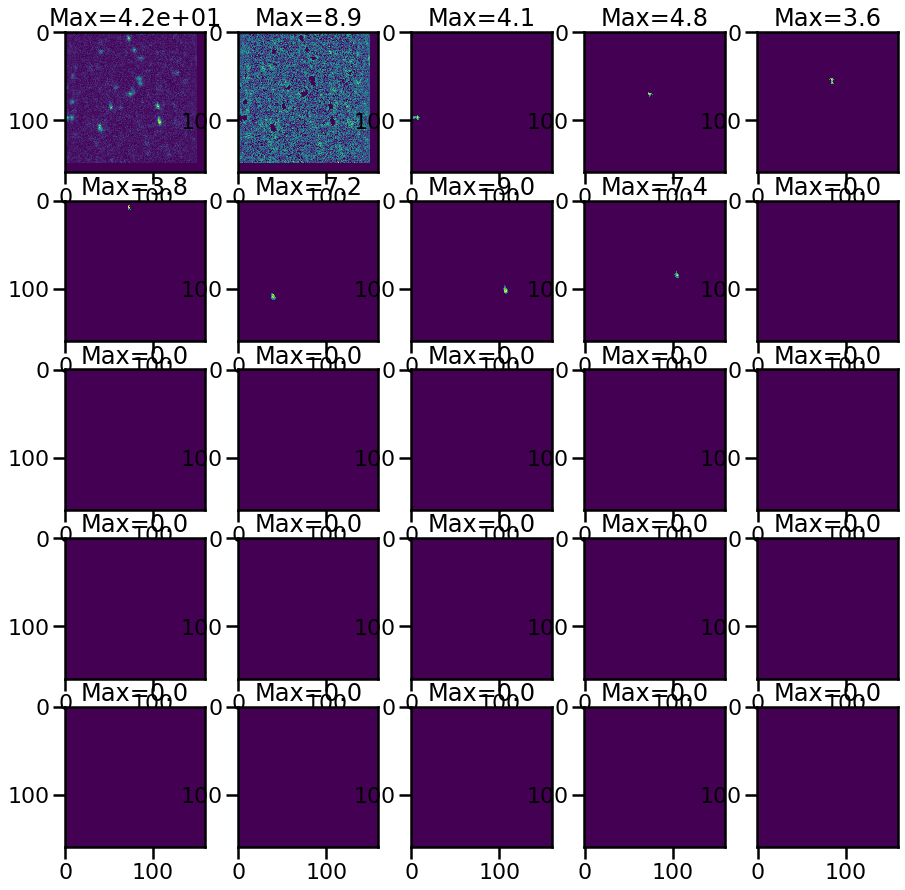

In [44]:
plot_25_clusters(next_cluster_image)

For t= 65


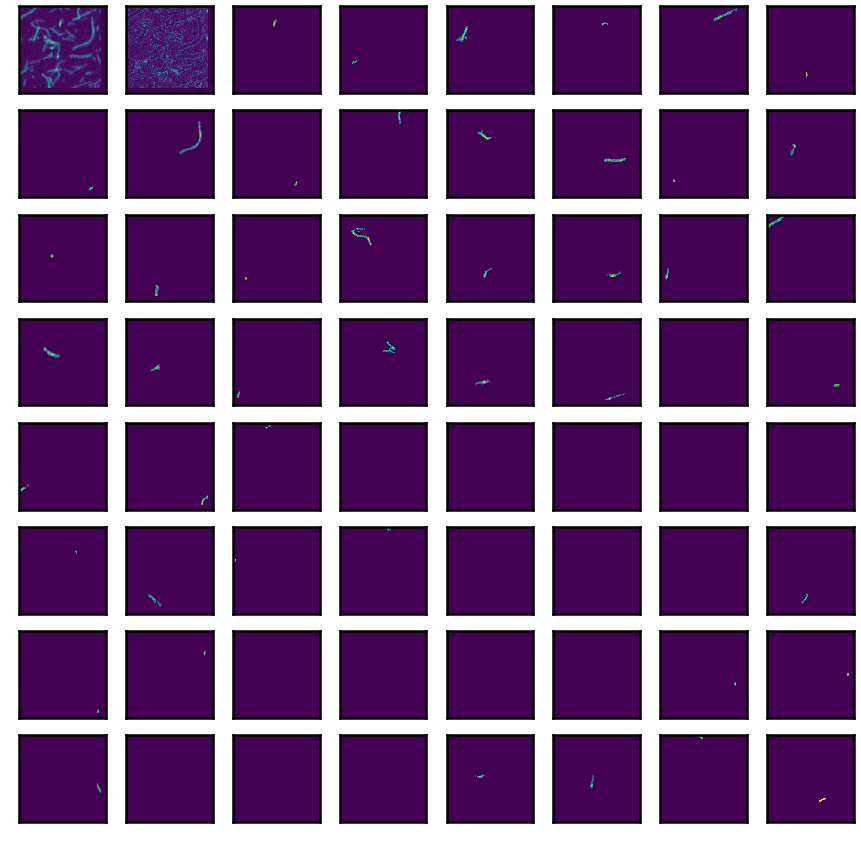

In [70]:
plot_whole_clusters(whole_cluster_imgs, region=4)

# Extract cluster information and save into a pandas dataframe

In [178]:
def generate_cluster_db(whole_cluster_imgs):
    cluster_N=0
    clusterDF=pd.DataFrame()
    PSF_mask_width = 7
    PSF_mask_size = PSF_mask_width**2
    
    non_inter_img=np.zeros(whole_cluster_imgs.shape[0:3])
    bkg_delays_mat = scipy.io.loadmat(f'{subdir}/bkg_delays.mat')
    bkg_delays=bkg_delays_mat['bkg_delays']    
    bkg_mean_record = np.zeros(whole_cluster_imgs.shape[4])
    
    for region in range(0,whole_cluster_imgs.shape[3]):
        print(f'Working on Region {region}')
        for imgseq in range(0,whole_cluster_imgs.shape[4]):
            # for FNet RELU we have a good estimation of the background level
            bkg_guess=whole_cluster_imgs[0:150,0:150,1,region,imgseq].mean() * 0.9 #slightly reduce the area of bkg img estimated
            
            #calculate background information
            non_bkg_index=np.array(list(range(2, whole_cluster_imgs.shape[2])))
            non_bkg_img=whole_cluster_imgs[...,non_bkg_index,region,imgseq].sum(2)
            non_bkg_img=non_bkg_img[0:150,0:150]
            
            bkg_img=whole_cluster_imgs[...,1,region,imgseq]
            bkg_img=bkg_img[0:150,0:150]
            bkg_mean=np.mean(bkg_img[(non_bkg_img<bkg_guess)])
            bkg_mean_record[imgseq] = bkg_mean
            
            bkg_delay_mean = bkg_delays[region,imgseq]
            
            non_inter_img.fill(0)
            cluster_img=whole_cluster_imgs[...,region,imgseq].copy()
            z_filled=find_z_unavailable(cluster_img)

            if len(z_filled)==0:
                z_filled_old=[]
                continue;

            if len(z_filled)==whole_cluster_imgs.shape[2]-2: #cluster channels are completely filled
                break;
                
            one_lifeimg_Acc_org=one_img(life_imgs,region=region,timepoint=imgseq,channel=0)
            one_lifeimg_Don_org=one_img(life_imgs,region=region,timepoint=imgseq,channel=1)       
            one_img_acc_org=one_img(imgs,region=region,timepoint=imgseq,channel=0)
            one_img_don_org=one_img(imgs,region=region,timepoint=imgseq,channel=1)

            for z in z_filled:
                excluding_index=np.array(list(range(2,z))+list(range(z+1, whole_cluster_imgs.shape[2])))
                including_img=whole_cluster_imgs[...,z,region,imgseq].copy()
                excluding_img=whole_cluster_imgs[...,excluding_index,region,imgseq].sum(2)
                #including_img[np.nonzero(excluding_img)]=0
                including_img[excluding_img>=bkg_mean]=0
                non_inter_img[...,z]=including_img
                
                backtrack = False
                bkg_mean = bkg_mean_record[imgseq]
                bkg_delay_mean = bkg_delays[region,imgseq]
                one_lifeimg_Acc=one_lifeimg_Acc_org
                one_lifeimg_Don=one_lifeimg_Don_org
                one_img_acc=one_img_acc_org
                one_img_don=one_img_don_org
                
                if imgseq==0: #first frame
                    cluster_id=cluster_N
                    cluster_N+=1
                else: #imgseq>0
                    if np.isin(z,z_filled_old): #it is not a new cluster
                        cluster_id=clusterDF[(clusterDF['Layer'] == z) & (clusterDF['Region'] == region) & (clusterDF['Timeframe']==(imgseq-1))]['ClusterID'].values[0]
                    else: #is a new cluster
                        cluster_id=cluster_N
                        cluster_N+=1
                        backtrack = True #back-track to the begining of the movie
   
                locations=np.array(np.nonzero(cluster_img[...,z]))
                locationsNI=np.array(np.nonzero(non_inter_img[...,z])) #non-intersecting locations
        
                cluster_size=locations.shape[1]
                cluster_sizeNI=locationsNI.shape[1]
                
                #acceptor info
                intenPixels_Acc=cluster_img[locations[0],locations[1],z]
                lifePixels_Acc=one_lifeimg_Acc[locations[0],locations[1]]
                
                #if its coverage is too small, then make it as large as the PSF size
                if (cluster_size < PSF_mask_size) and (cluster_sizeNI==cluster_size): #try to expand ROI, unless there is an overlap. Later these clusters can be eliminated: Size<49
                    #find the centroid
                    #print(intenPixels_Acc)
                    #print(np.array(locations[0]))
                    #print(intenPixels_Acc.sum())
                    
                    i_center = int(np.round((np.array(locations[0])*intenPixels_Acc).sum()/intenPixels_Acc.sum()))
                    j_center = int(np.round((np.array(locations[1])*intenPixels_Acc).sum()/intenPixels_Acc.sum()))
                    
                    i_min = max(i_center - PSF_mask_width//2, 0)
                    j_min = max(j_center - PSF_mask_width//2, 0)
                    i_max = min(i_center + PSF_mask_width//2, 149)
                    j_max = min(j_center + PSF_mask_width//2, 149)
                    
                    cluster_img_temp = cluster_img[...,z].copy()
                    cluster_img_temp[i_min:i_max+1,j_min:j_max+1]=one_img_acc[i_min:i_max+1,j_min:j_max+1]
                    
                    including_img=cluster_img_temp.copy()
                    including_img[excluding_img>=bkg_mean]=0
                    
                    locations=np.array(np.nonzero(cluster_img_temp))
                    locationsNI=np.array(np.nonzero(including_img)) #non-intersecting locations
                    
                    cluster_size=locations.shape[1]
                    cluster_sizeNI=locationsNI.shape[1]
                    
                    non_inter_img[...,z]=including_img
                    cluster_img[...,z] = cluster_img_temp
                        
                    if cluster_sizeNI< cluster_size:
                        locations = locationsNI
                        cluster_size = cluster_sizeNI
                        cluster_img[...,z] = including_img
                        backtrack = False #if there's an overlap, don't backtrack
                    #acceptor info
                    intenPixels_Acc=cluster_img[locations[0],locations[1],z]
                    lifePixels_Acc=one_lifeimg_Acc[locations[0],locations[1]]
                elif backtrack: #it's already big. So, it is not grown on the surface
                    backtrack = False
          
                if cluster_sizeNI< cluster_size:
                    backtrack = False      

                meanAccIntensity=intenPixels_Acc.mean()
                meanAccLife=lifePixels_Acc.mean()
                
                #donor info
                intenPixels_Don=one_img_don[locations[0],locations[1]]        
                lifePixels_Don=one_lifeimg_Don[locations[0],locations[1]]
                meanDonIntensity=intenPixels_Don.mean()
                meanDonLife=lifePixels_Don.mean()

                #acceptor info NI
                intenPixels_AccNI=cluster_img[locationsNI[0],locationsNI[1],z]
                lifePixels_AccNI=one_lifeimg_Acc[locationsNI[0],locationsNI[1]]
                meanAccIntensityNI=intenPixels_AccNI.mean()
                meanAccLifeNI=lifePixels_AccNI.mean()
                
                #donor info
                intenPixels_DonNI=one_img_don[locationsNI[0],locationsNI[1]]        
                lifePixels_DonNI=one_lifeimg_Don[locationsNI[0],locationsNI[1]]
                meanDonIntensityNI=intenPixels_DonNI.mean()
                meanDonLifeNI=lifePixels_DonNI.mean()
                
                meanAccIntensityNI_bkgcor=meanAccIntensityNI-bkg_mean
                meanAccLifeNI_bkgcor=np.sum(intenPixels_AccNI*lifePixels_AccNI-bkg_mean*bkg_delay_mean)/np.sum(intenPixels_AccNI-bkg_mean)
                
                boundary = is_boundary(locations)
                
                clusterDF=clusterDF.append({'Subfolder' : subdir , 'Region' : region, 'Timeframe': imgseq, 'ClusterID':cluster_id,
                                    'Layer':z, 'Locations':locations, 'LocationsNI':locationsNI,
                                    'IntenPixelsAcc': intenPixels_Acc, 'LifePixelsAcc': lifePixels_Acc,
                                    'IntenPixelsAccNI': intenPixels_AccNI, 'LifePixelsAccNI': lifePixels_AccNI,
                                    'MeanIntenAcc':meanAccIntensity, 'MeanLifeAcc':meanAccLife,
                                    'MeanIntenAccNI':meanAccIntensityNI, 'MeanLifeAccNI':meanAccLifeNI,
                                    'MeanIntenAccNI_bkgcor':meanAccIntensityNI_bkgcor, 'MeanLifeAccNI_bkgcor':meanAccLifeNI_bkgcor,
                                    'bkg_mean':bkg_mean, 'bkg_delay_mean':bkg_delay_mean,
                                    'IntenPixelsDon': intenPixels_Don, 'LifePixelsDon': lifePixels_Don,
                                    'IntenPixelsDonNI': intenPixels_DonNI, 'LifePixelsDonNI': lifePixels_DonNI,
                                    'MeanIntenDon':meanDonIntensity, 'MeanLifeDon':meanDonLife,
                                    'MeanIntenDonNI':meanDonIntensityNI, 'MeanLifeDonNI':meanDonLifeNI,
                                    'Size': cluster_size, 'SizeNI': cluster_sizeNI, 'backtrack': 0, 'backtrack_init': 0, 'Boundary': boundary} , ignore_index=True)
                if backtrack:
                    imgseq_temp = imgseq - 1
                    while imgseq_temp>-1:
                        if imgseq_temp==(imgseq - 1):
                            backtrack_init = 1
                        else:
                            backtrack_init = 0
                        
                        bkg_mean = bkg_mean_record[imgseq_temp]
                        bkg_delay_mean = bkg_delays[region,imgseq_temp]
                        
                        one_lifeimg_Acc=one_img(life_imgs,region=region,timepoint=imgseq_temp,channel=0)
                        one_lifeimg_Don=one_img(life_imgs,region=region,timepoint=imgseq_temp,channel=1)       
                        one_img_acc=one_img(imgs,region=region,timepoint=imgseq_temp,channel=0)
                        one_img_don=one_img(imgs,region=region,timepoint=imgseq_temp,channel=1)
                        
                        intenPixels_Acc=one_img_acc[locations[0],locations[1]]
                        
                        i_center = np.round((np.array(locations[0])*intenPixels_Acc).sum()/intenPixels_Acc.sum())
                        j_center = np.round((np.array(locations[1])*intenPixels_Acc).sum()/intenPixels_Acc.sum())
                        
                        if np.isnan(i_center):
                            i_center = int(round(np.array(locations[0]).mean()))
                        else:
                            i_center = int(i_center)
                        
                        if np.isnan(j_center):
                            j_center = int(round(np.array(locations[1]).mean()))
                        else:
                            j_center = int(j_center)
                        
                        i_min = max(i_center - PSF_mask_width//2, 0)
                        j_min = max(j_center - PSF_mask_width//2, 0)
                        i_max = min(i_center + PSF_mask_width//2, 149)
                        j_max = min(j_center + PSF_mask_width//2, 149)
                        
                        cluster_img[...,z].fill(0)
                        cluster_img[i_min:i_max+1,j_min:j_max+1,z]=one_img_acc[i_min:i_max+1,j_min:j_max+1]
                        
                        including_img=cluster_img[...,z].copy()
                        # for this backtracking, non-intersecting img will not be calculated

                        locations=np.array(np.nonzero(cluster_img[...,z]))
                        locationsNI=locations

                        cluster_size=locations.shape[1]
                        cluster_sizeNI=locationsNI.shape[1]

                        #acceptor info
                        intenPixels_Acc=cluster_img[locations[0],locations[1],z]
                        lifePixels_Acc=one_lifeimg_Acc[locations[0],locations[1]]
                        meanAccIntensity=intenPixels_Acc.mean()
                        meanAccLife=lifePixels_Acc.mean()

                        #donor info
                        intenPixels_Don=one_img_don[locations[0],locations[1]]        
                        lifePixels_Don=one_lifeimg_Don[locations[0],locations[1]]
                        meanDonIntensity=intenPixels_Don.mean()
                        meanDonLife=lifePixels_Don.mean()

                        #acceptor info NI
                        intenPixels_AccNI=cluster_img[locationsNI[0],locationsNI[1],z]
                        lifePixels_AccNI=one_lifeimg_Acc[locationsNI[0],locationsNI[1]]
                        meanAccIntensityNI=intenPixels_AccNI.mean()
                        meanAccLifeNI=lifePixels_AccNI.mean()

                        #donor info
                        intenPixels_DonNI=one_img_don[locationsNI[0],locationsNI[1]]        
                        lifePixels_DonNI=one_lifeimg_Don[locationsNI[0],locationsNI[1]]
                        meanDonIntensityNI=intenPixels_DonNI.mean()
                        meanDonLifeNI=lifePixels_DonNI.mean()

                        meanAccIntensityNI_bkgcor=meanAccIntensityNI-bkg_mean
                        meanAccLifeNI_bkgcor=np.sum(intenPixels_AccNI*lifePixels_AccNI-bkg_mean*bkg_delay_mean)/np.sum(intenPixels_AccNI-bkg_mean)

                        boundary = is_boundary(locations)
                        
                        clusterDF=clusterDF.append({'Subfolder' : subdir , 'Region' : region, 'Timeframe': imgseq_temp, 'ClusterID':cluster_id,
                                            'Layer':z, 'Locations':locations, 'LocationsNI':locationsNI,
                                            'IntenPixelsAcc': intenPixels_Acc, 'LifePixelsAcc': lifePixels_Acc,
                                            'IntenPixelsAccNI': intenPixels_AccNI, 'LifePixelsAccNI': lifePixels_AccNI,
                                            'MeanIntenAcc':meanAccIntensity, 'MeanLifeAcc':meanAccLife,
                                            'MeanIntenAccNI':meanAccIntensityNI, 'MeanLifeAccNI':meanAccLifeNI,
                                            'MeanIntenAccNI_bkgcor':meanAccIntensityNI_bkgcor, 'MeanLifeAccNI_bkgcor':meanAccLifeNI_bkgcor,
                                            'bkg_mean':bkg_mean, 'bkg_delay_mean':bkg_delay_mean,
                                            'IntenPixelsDon': intenPixels_Don, 'LifePixelsDon': lifePixels_Don,
                                            'IntenPixelsDonNI': intenPixels_DonNI, 'LifePixelsDonNI': lifePixels_DonNI,
                                            'MeanIntenDon':meanDonIntensity, 'MeanLifeDon':meanDonLife,
                                            'MeanIntenDonNI':meanDonIntensityNI, 'MeanLifeDonNI':meanDonLifeNI,
                                            'Size': cluster_size, 'SizeNI': cluster_sizeNI, 'backtrack': 1, 'backtrack_init': backtrack_init, 'Boundary': boundary} , ignore_index=True)
                        
                        imgseq_temp-=1
            z_filled_old=z_filled #save previous cluster z informations
        gc.collect()

    return clusterDF.copy()

In [179]:
clusterDF=generate_cluster_db(whole_cluster_imgs)

In [207]:
clusterDF

,ClusterID,IntenPixelsAcc,IntenPixelsDon,Layer,LifePixelsAcc,Locations,MeanIntenAcc,MeanIntenDon,MeanLifeAcc,MeanLifeDon,Region,Size,Subfolder,Timeframe
0,0.0,"[0.8255338072776794, 0.8044815063476562, 0.809...","[1.0215348353041025, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2.0,"[6.434e-09, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[18, 18, 19, 19, 19, 19, 20, 20, 20, 20, 20, ...",0.800284,0.397264,5.170792e-09,9.542222e-10,0.0,18.0,20190617Avi48859442500nMImmoliVideo16subregions,0.0
1,1.0,"[0.8403584957122803, 0.8296346664428711, 0.801...","[0.0, 0.0, 0.0, 0.0, 0.0, 2.0415300324280063, ...",2.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 3.843e-09, 7.856e-09...","[[27, 28, 28, 28, 29, 29, 30, 30, 30, 31, 31],...",0.809720,0.742375,4.580760e-09,2.112818e-09,1.0,11.0,20190617Avi48859442500nMImmoliVideo16subregions,0.0
2,2.0,"[0.8263280391693115, 0.8341408967971802, 0.865...","[1.0206370888616083, 0.0, 0.0, 0.0, 1.02063708...",2.0,"[6.76e-09, 0.0, 0.0, 0.0, 2.552e-09, 8.798e-09...","[[89, 89, 89, 89, 90, 90, 90, 91, 91, 91, 91, ...",0.837642,0.291611,3.192000e-09,4.461857e-09,3.0,14.0,20190617Avi48859442500nMImmoliVideo16subregions,0.0
3,3.0,"[0.7986575961112976, 0.8126521706581116, 0.810...","[0.0, 1.0191491932004348, 0.0, 1.0673268164521...",2.0,"[0.0, 2.272e-09, 0.0, 7.546e-09, 3.12199999999...","[[16, 17, 17, 17, 17, 17, 18, 18, 19, 19, 19, ...",0.812444,0.622431,3.823503e-09,3.406833e-09,8.0,12.0,20190617Avi48859442500nMImmoliVideo16subregions,0.0
4,4.0,"[7.476624233112948, 7.318197830318604, 7.98131...","[0.6981889742304577, 0.7333989682248414, 0.0, ...",2.0,"[2.0999999999999998e-09, 1.63e-09, 0.0, 1.3562...","[[129, 129, 129, 130, 130, 131, 131, 131, 132,...",10.036167,1.137692,4.955647e-09,3.928318e-09,11.0,11.0,20190617Avi48859442500nMImmoliVideo16subregions,0.0
5,5.0,"[7.808641159637983, 7.089449028906575, 8.81642...","[4.549605683536486, 1.1150342205219606, 0.0, 0...",3.0,"[7.0105e-09, 5.65e-09, 0.0, 0.0, 0.0, 0.0, 0.0...","[[94, 94, 95, 95, 96, 96, 97, 97, 98, 98, 99, ...",8.501130,0.472053,3.243192e-09,1.055042e-09,11.0,12.0,20190617Avi48859442500nMImmoliVideo16subregions,0.0
6,6.0,"[0.8251573443412781, 0.8388136625289917, 0.802...","[0.0, 1.0210052220537198, 0.0, 1.0210052220537...",4.0,"[0.0, 2.404e-09, 0.0, 4.5484e-08, 2.27e-09, 0....","[[121, 121, 121, 122, 122, 122, 122, 123, 123,...",0.818559,0.765754,3.576337e-09,4.291958e-09,11.0,16.0,20190617Avi48859442500nMImmoliVideo16subregions,0.0
7,7.0,"[0.8327465057373047, 0.8767053484916687, 0.827...","[0.0, 0.0, 0.0, 1.1185541702456117, 0.0, 0.0, ...",2.0,"[0.0, 0.0, 0.0, 6.542e-09, 0.0, 0.0, 0.0, 0.0,...","[[30, 30, 30, 31, 31, 31, 31, 31, 31, 31, 32, ...",0.849869,0.073743,4.094435e-09,3.742069e-10,13.0,29.0,20190617Avi48859442500nMImmoliVideo16subregions,0.0
8,8.0,"[7.956331970591428, 14.392079997202346, 8.1239...","[8.161052102002355, 13.261709665754136, 4.0805...",2.0,"[3.106e-09, 2.422923076923077e-09, 3.078e-09, ...","[[102, 102, 102, 103, 103, 103, 104, 104, 104,...",16.383596,12.323189,4.896100e-09,2.225163e-09,14.0,25.0,20190617Avi48859442500nMImmoliVideo16subregions,0.0
9,9.0,"[0.8397095203399658, 0.8363043665885925, 0.833...","[0.0, 0.0, 0.0, 0.0, 2.040263025500594, 0.0, 0...",3.0,"[0.0, 0.0, 0.0, 0.0, 5.934e-09, 0.0, 0.0, 7.36...","[[125, 125, 125, 125, 126, 126, 127, 127, 128,...",0.811659,1.334018,2.794383e-09,2.383051e-09,14.0,13.0,20190617Avi48859442500nMImmoliVideo16subregions,0.0
